In [1]:
### Applies a random X rotation to one of the physical qubits in your system (randomly) ### 
def random_qubit_x_error(logical_state, qubit_range = None):
    # logical_state: The logical state of the three qubit system you wish to apply the error to
    # qubit_range: The indices you want to consider in your error application (starts at 1)
    
    # total number of qubits in your system
    n = int(np.log(len(logical_state))/np.log(2))
    
    # Choose the index of the qubit you want to apply the error to.
    error_index = random.randint(-1,n-1)
    if qubit_range != None:
        if error_index != -1:
            error_index = random.randint(qubit_range[0], qubit_range[1])
             
    # Apply the error depending on the index
    if error_index == -1:
        errored_logical_state = logical_state
    else:   
        error_gate = np.kron(np.identity(2**(error_index)), np.kron(sigma_x, np.identity(2**(n-error_index-1))))
        errored_logical_state = np.dot(error_gate, logical_state)

    return errored_logical_state, error_index

### Applies a random Z rotation to one of the physical qubits in your system (randomly) ### 
def random_qubit_z_error(logical_state, qubit_range = None):
    # logical_state: The logical state of the three qubit system you wish to apply the error to
    # qubit_range: The indices you want to consider in your error application (starts at 1)
   
    # total number of qubits in your system
    n = int(np.log(len(logical_state))/np.log(2))
    
    # Choose the index of the qubit you want to apply the error to.
    error_index = random.randint(-1,n-1)
    if qubit_range != None:
        if error_index != -1:
            error_index = random.randint(qubit_range[0], qubit_range[1])
             
    # Apply the error depending on the index
    if error_index == -1:
        errored_logical_state = logical_state
    else:   
        error_gate = np.kron(np.identity(2**(error_index)), np.kron(sigma_z, np.identity(2**(n-error_index-1))))
        errored_logical_state = np.dot(error_gate, logical_state)

    return errored_logical_state, error_index



# 9-Qubit Error Correcting Code


#### In this notebook, we will show the functionality of the First Full Quantum Code.
#### We will refer back to the 3-Qubit Code, as the 9-Qubit Code is a repetition code.

In [2]:
import numpy as np

# Importing required libraries
from general_qec.qec_helpers import *
from general_qec.gates import *
from general_qec.errors import *

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace

import random
from qiskit.extensions import UnitaryGate



# Visualization of circuits: Initializing backend simulators
qasm_sim = Aer.get_backend('qasm_simulator')
sv_sim = Aer.get_backend('statevector_simulator')

# Setting mpl as default drawer
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')



env: QISKIT_SETTINGS={}


## 3 Qubit Code Review

#### The 3 Qubit Code was shown to only be able to correct $\sigma_x$ (Bit-Flip) Errors
#### Only able to correct for one type of error at a time


### For $\sigma_z$ (Phase-Flip) Errors, does the error detection circuit signal an error?
#### We can build a circuit that detects phase-flip instead of bit-flip errors,
#### by instead encoding the qubits in a GHZ state in the $|±\rangle$ basis:
$\alpha|0\rangle + \beta|1\rangle \rightarrow \alpha|000\rangle + \beta|111\rangle \rightarrow \alpha|+ + +\rangle + 
\beta|− − −\rangle $



### Gate Operations Review ( CX and CZ ):



#### The CNOT gate is typically used to establish entanglement between qubits and implement controlled operations. 


#### CNOT gate matrix representation:  $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}$$


#### The CZ gate, also known as the HGZ gate, is a two-qubit gate that introduces a phase shift of $\pi$ to the qubit state. 
#### Phase Shift: Refers to a change in the timing or alignment of a wave or oscillation. 


#### The Z gate is represented by the following matrix: $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}$$



####  When applied to the $\vert0\rangle$ state, 
$$Z\vert0\rangle = \vert0\rangle$$

#### However, when applied to the $\vert1\rangle$ state, the Z gate introduces a phase shift of $\pi$ (or a phase flip) to the state.  
$$Z\vert1\rangle = -\vert1\rangle$$





### Foundations of Correction

#### This algorithm a single logical qubit,  encoded using 9 physical qubits.
#### Able to correct for both a single $\sigma_x$ error per block of 3 Qubits (bit flip) 
#### and for a $\sigma_z$ (phase-flip). 

#### In this case we will define our two logical states as $\vert0\rangle_L$ and $\vert1\rangle_L$ where $|0\rangle_L = \frac{1}{\sqrt{8}} \left( |000\rangle + |111\rangle \right) \left( |000\rangle + |111\rangle \right) \left( |000\rangle + |111\rangle \right)$ and
$|1\rangle_L = \frac{1}{\sqrt{8}} \left( |000\rangle - |111\rangle \right) \left( |000\rangle - |111\rangle \right) \left( |000\rangle - |111\rangle \right)$ and $\vert1\rangle_L = \vert111\rangle$

#### A single qubit state is still represented by $\vert\psi\rangle_L = \alpha\vert0\rangle_L + \beta\vert1\rangle_L$




#### Below we show the quantum circuit for encoding a single logical qubit in a 9-qubit system.

## Implementing for $\sigma_x$ correction: Logical state of a 9 Qubit Code

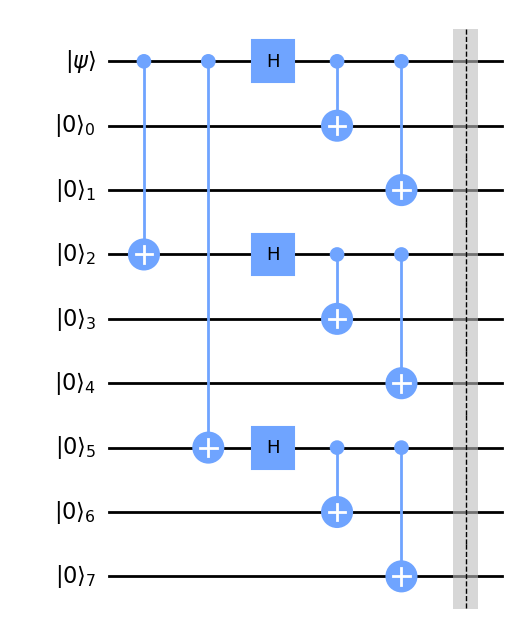

In [52]:

psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')

qc = QuantumCircuit(psi, ancilla)
qc.cnot(0, 3)
qc.cnot(0, 6)
qc.h(0)
qc.h(3)
qc.h(6)
qc.cnot(0, 1)
qc.cnot(3, 4)
qc.cnot(6, 7)
qc.cnot(0, 2)
qc.cnot(3, 5)
qc.cnot(6, 8)
qc.barrier()

qc.draw()
 

    
 

In [53]:

def nine_qubit_initialize_logical_state(initial_psi):
    initial_ancilla_state = np.array([1, 0])
    psi = initial_psi

    # Initializing the logical state with 8 ancillas
    initial_logical_state = np.kron(psi, np.kron(initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(
        initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(
            initial_ancilla_state,np.kron(initial_ancilla_state, initial_ancilla_state))))))))


    np.shape(initial_logical_state)

    # First two non-adjacent qubits on the left
    current_state = np.dot(CNOT(0, 3, 9), initial_logical_state)
    current_state = np.dot(CNOT(0, 6, 9), current_state)

    # All three Hadamard gates
    hadamards = np.kron(hadamard, np.kron(np.identity(2**2), np.kron(hadamard, np.kron(
        np.identity(2**2), np.kron(hadamard, np.identity(2**2))))))

    current_state = np.dot(hadamards, current_state)

    # The three adjacent qubits                                                                       
    current_state = np.dot(CNOT(0, 1, 9), current_state)
    current_state = np.dot(CNOT(3, 4, 9), current_state)
    current_state = np.dot(CNOT(6, 7, 9) , current_state)

    # Last three qubits
    current_state = np.dot(CNOT(0, 2, 9) , current_state)
    current_state = np.dot(CNOT(3, 5, 9) , current_state)
    current_state = np.dot(CNOT(6, 8, 9) , current_state)

    final_logical_state = np.kron(current_state, np.kron(np.array([1, 0]), np.array([1,0])))

    k = 9
    bit_representation = vector_state_to_bit_state(final_logical_state, k)[0]
    
    return final_logical_state

# Example usage
initial_psi = np.array([0, 1])
state = nine_qubit_initialize_logical_state(initial_psi)
print_state_info(state, 9)

000000000 :  0.3535533905932737
000000111 :  -0.3535533905932737
000111000 :  -0.3535533905932737
000111111 :  0.3535533905932737
111000000 :  -0.3535533905932737
111000111 :  0.3535533905932737
111111000 :  0.3535533905932737
111111111 :  -0.3535533905932737


## Initializing for our Phase Correction

### 9 Qubit Phase Flip Error Detection & Correction




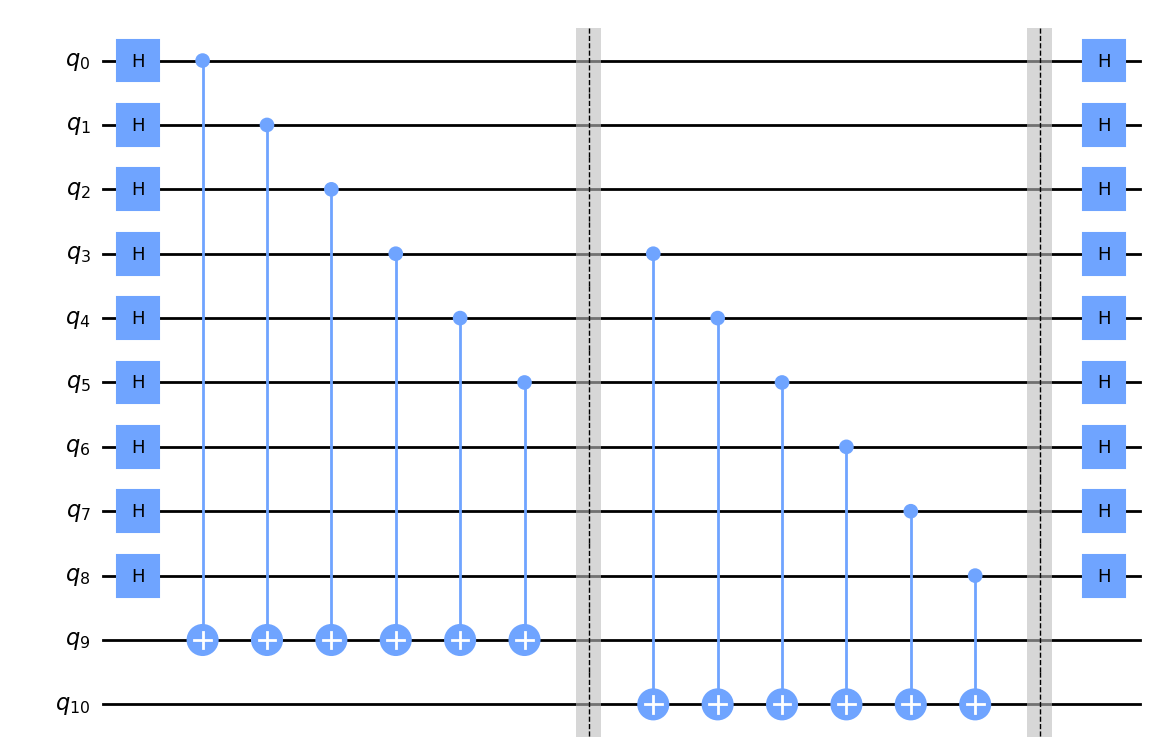

In [54]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')
additional_ancilla = QuantumRegister(10, '|0⟩')
qc = QuantumCircuit(11)

# Hadamard gates on the left side (vertical arrangement)
for i in range(9):
    qc.h(i)

# Define the Z error correction circuit for Shor's code
qc.cx(0, 9)
qc.cx(1, 9)
qc.cx(2, 9)
qc.cx(3, 9)
qc.cx(4, 9)
qc.cx(5, 9)
qc.barrier()
qc.cx(3, 10)
qc.cx(4, 10)
qc.cx(5, 10)
qc.cx(6, 10)
qc.cx(7, 10)
qc.cx(8, 10)

# Add barrier gate after the error correction circuit
qc.barrier()

# Hadamard gates on the right side (vertical arrangement)
for i in range(9):
    qc.h(i)
qc.draw()



In [55]:
# adding in ancilla qubits
zero = np.array([1, 0])
vector_state = np.kron(state, np.kron(zero, zero))
print_state_info(vector_state, 11)

00000000000 :  0.3535533905932737
00000011100 :  -0.3535533905932737
00011100000 :  -0.3535533905932737
00011111100 :  0.3535533905932737
11100000000 :  -0.3535533905932737
11100011100 :  0.3535533905932737
11111100000 :  0.3535533905932737
11111111100 :  -0.3535533905932737


In [56]:
def nine_qubit_corrected_phase_flip(logical_state):
    # logical_state: the full vector state representation of your 11 qubit system (9 data, 2 ancilla)
                                                 
     # First Nine Hadamard gates
    hadamards = np.kron(hadamard, np.kron(hadamard, np.kron(hadamard, np.kron(
       hadamard, np.kron(hadamard, np.kron(hadamard, np.kron(
       hadamard, np.kron(hadamard, np.kron(hadamard, np.identity(2**2))))))))))

    current_state = np.dot(hadamards, logical_state)                                            
                                                 
                                                 
    # First Set of 6 CNOTS (We use two sets to detect sign differences)
    current_state = np.dot(CNOT(0, 9, 11), current_state)
    current_state = np.dot(CNOT(1, 9, 11), current_state)
    current_state = np.dot(CNOT(2, 9, 11), current_state)
    current_state = np.dot(CNOT(3, 9, 11), current_state)
    current_state = np.dot(CNOT(4, 9, 11), current_state)
    current_state = np.dot(CNOT(5, 9, 11), current_state)
                        
                        
    # Second Set of 6 CNOTS 
    current_state = np.dot(CNOT(3, 10, 11), current_state)
    current_state = np.dot(CNOT(4, 10, 11), current_state)
    current_state = np.dot(CNOT(5, 10, 11), current_state)
    current_state = np.dot(CNOT(6, 10, 11), current_state)
    current_state = np.dot(CNOT(7, 10, 11), current_state)
    current_state = np.dot(CNOT(8, 10, 11), current_state)
    
                        
    # Hadamards applied to each qubit on the right
    final_state = np.dot(hadamards, current_state) 
    final_state[np.abs(final_state) < 1e-15] = 0
    
    
    # Measure ancilla qubits
    final_state = collapse_ancilla(final_state, 2)
    
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]
    
    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]
    
    if (a1 == '0') and (a2 == '0'):
        print('No Phase Error Occured')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '0'):
        print('Phase Error in block 1')
        operation = np.kron(sigma_z, np.identity(2**10))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Phase Error in block 3')
        operation = np.kron(np.identity(2**6),np.kron(sigma_z, np.identity(2**4)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '1'):
        print('Phase Error in block 2')
        operation = np.kron(np.identity(2**3), np.kron(sigma_z, np.identity(2**7)))
        corrected_state = np.dot(operation, final_state)
    
    return corrected_state

# Example usage
final_state = nine_qubit_corrected_phase_flip(state)

print_state_info(final_state, 11)


No Phase Error Occured
00000000000 :  (0.3535533905932731+0j)
00000011100 :  (-0.3535533905932731+0j)
00011100000 :  (-0.3535533905932731+0j)
00011111100 :  (0.3535533905932731+0j)
11100000000 :  (-0.3535533905932731+0j)
11100011100 :  (0.3535533905932731+0j)
11111100000 :  (0.3535533905932731+0j)
11111111100 :  (-0.3535533905932731+0j)


In [57]:
errored_state = random_qubit_z_error(state, qubit_range = [0,8])[0]
print_state_info(errored_state, 11)

00000000000 :  0.3535533905932737
00000011100 :  0.3535533905932737
00011100000 :  -0.3535533905932737
00011111100 :  -0.3535533905932737
11100000000 :  -0.3535533905932737
11100011100 :  -0.3535533905932737
11111100000 :  0.3535533905932737
11111111100 :  0.3535533905932737


In [58]:
corrected_state = nine_qubit_corrected_phase_flip(errored_state)
print_state_info(corrected_state, 11)

Phase Error in block 3
00000000001 :  (0.3535533905932731+0j)
00000011101 :  (-0.3535533905932731+0j)
00011100001 :  (-0.3535533905932731+0j)
00011111101 :  (0.3535533905932731+0j)
11100000001 :  (-0.3535533905932731+0j)
11100011101 :  (0.3535533905932731+0j)
11111100001 :  (0.3535533905932731+0j)
11111111101 :  (-0.3535533905932731+0j)


In [59]:
reset_state = ancilla_reset(corrected_state, 2)
print_state_info(reset_state, 11)

00000000000 :  (0.3535533905932731+0j)
00000011100 :  (-0.3535533905932731+0j)
00011100000 :  (-0.3535533905932731+0j)
00011111100 :  (0.3535533905932731+0j)
11100000000 :  (-0.3535533905932731+0j)
11100011100 :  (0.3535533905932731+0j)
11111100000 :  (0.3535533905932731+0j)
11111111100 :  (-0.3535533905932731+0j)


## Bit-Flip Error Detection and Correction

In [68]:
    
# First block  

def first_block(logical_state):
    
    # We will treat this initialization in three blocks 
    # Each of the three (imaginary) blocks of the 9 Qubit Code, 
    # correspond to same behavior of the three qubit system.

    current_state = np.dot(CNOT(0, 9, 11), logical_state)   
    current_state = np.dot(CNOT(1, 9, 11), current_state)
    current_state = np.dot(CNOT(0, 10, 11), current_state)
    current_state = np.dot(CNOT(2, 10, 11), current_state)
    
       
    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]
    
    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]
    
    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occured')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1')
        operation = np.kron(sigma_x, np.identity(2**10))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2')
        operation = np.kron(np.identity(2), np.kron(sigma_x, np.identity(2**9)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3')
        operation = np.kron(np.identity(2**2), np.kron(sigma_x, np.identity(2**8)))
        corrected_state = np.dot(operation, final_state)
    
    return corrected_state


    
# Second Block
def second_block(logical_state): 
    # Second Block
    current_state = np.dot(CNOT(3, 9, 11), logical_state)
    current_state = np.dot(CNOT(4, 9, 11), current_state)
    current_state = np.dot(CNOT(3, 10, 11), current_state)
    current_state = np.dot(CNOT(5, 10, 11), current_state)
    
       
    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]
    
    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]
    
    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occured')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1')
        operation = np.kron(np.identity(2**3),np.kron(sigma_x, np.identity(2**7)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2')
        operation = np.kron(np.identity(2**4),np.kron(sigma_x, np.identity(2**6)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3')
        operation = np.kron(np.identity(2**5),np.kron(sigma_x, np.identity(2**5)))
        corrected_state = np.dot(operation, final_state)
    
    return corrected_state


# Third Block 
def third_block(logical_state):
    # Third Block
    current_state = np.dot(CNOT(6, 9, 11), logical_state)
    current_state = np.dot(CNOT(7, 9, 11), current_state)
    current_state = np.dot(CNOT(6, 10, 11), current_state)
    current_state = np.dot(CNOT(8, 10, 11), current_state)
    
       
    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]
    
    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]
    
    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occured')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1')
        operation = np.kron(np.identity(2**6),np.kron(sigma_x, np.identity(2**4)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2')
        operation = np.kron(np.identity(2**7),np.kron(sigma_x, np.identity(2**3)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3')
        operation = np.kron(np.identity(2**8),np.kron(sigma_x, np.identity(2**2)))
        corrected_state = np.dot(operation, final_state)
    
    return corrected_state   
    

In [69]:
print_state_info(reset_state, 11)

00000000000 :  (0.3535533905932731+0j)
00000011100 :  (-0.3535533905932731+0j)
00011100000 :  (-0.3535533905932731+0j)
00011111100 :  (0.3535533905932731+0j)
11100000000 :  (-0.3535533905932731+0j)
11100011100 :  (0.3535533905932731+0j)
11111100000 :  (0.3535533905932731+0j)
11111111100 :  (-0.3535533905932731+0j)


In [70]:
# This cell is specific to block 1  
errored_state = random_qubit_x_error(reset_state, [0,2])[0]   # The [0,2] show qubits 1,2, and 3
print_state_info(errored_state, 11)

01000000000 :  (0.3535533905932731+0j)
01000011100 :  (-0.3535533905932731+0j)
01011100000 :  (-0.3535533905932731+0j)
01011111100 :  (0.3535533905932731+0j)
10100000000 :  (-0.3535533905932731+0j)
10100011100 :  (0.3535533905932731+0j)
10111100000 :  (0.3535533905932731+0j)
10111111100 :  (-0.3535533905932731+0j)


In [71]:
# This cell is specific to block 2  
errored_state = random_qubit_x_error(errored_state, [3,5])[0]   # The [3,5] show qubits 4,5, and 6
print_state_info(errored_state, 11)

01001100000 :  (-0.3535533905932731+0j)
01001111100 :  (0.3535533905932731+0j)
01010000000 :  (0.3535533905932731+0j)
01010011100 :  (-0.3535533905932731+0j)
10101100000 :  (0.3535533905932731+0j)
10101111100 :  (-0.3535533905932731+0j)
10110000000 :  (-0.3535533905932731+0j)
10110011100 :  (0.3535533905932731+0j)


In [72]:
# This cell is specific to block 3
errored_state = random_qubit_x_error(errored_state, [6,8])[0]   # The [6,8] show qubits 7,8, and 9
print_state_info(errored_state, 11)


01001100000 :  (-0.3535533905932731+0j)
01001111100 :  (0.3535533905932731+0j)
01010000000 :  (0.3535533905932731+0j)
01010011100 :  (-0.3535533905932731+0j)
10101100000 :  (0.3535533905932731+0j)
10101111100 :  (-0.3535533905932731+0j)
10110000000 :  (-0.3535533905932731+0j)
10110011100 :  (0.3535533905932731+0j)


### Performing error correction per block
#### 11 = Bit Error on Qubit 1
#### 10 = Bit Error on Qubit 2
#### 01 = Bit Error on Qubit 3

In [73]:
# This cell is specific to block 1 
corrected_first_block_state = first_block(errored_state)
print_state_info(corrected_first_block_state, 11)

Bit Error in qubit 2
00001100010 :  (-0.3535533905932731+0j)
00001111110 :  (0.3535533905932731+0j)
00010000010 :  (0.3535533905932731+0j)
00010011110 :  (-0.3535533905932731+0j)
11101100010 :  (0.3535533905932731+0j)
11101111110 :  (-0.3535533905932731+0j)
11110000010 :  (-0.3535533905932731+0j)
11110011110 :  (0.3535533905932731+0j)


In [74]:
# This cell is specific to block 2
# Now, we need to reset the ancillas
#collapse_ancilla(errored_state, 11)
errored_state =ancilla_reset(errored_state, 2) 
#reset_state = ancilla_reset(corrected_state, 2)

corrected_second_block_state = second_block(errored_state)
print_state_info(corrected_second_block_state, 11)

Bit Error in qubit 1
01000000011 :  (0.3535533905932731+0j)
01000011111 :  (-0.3535533905932731+0j)
01011100011 :  (-0.3535533905932731+0j)
01011111111 :  (0.3535533905932731+0j)
10100000011 :  (-0.3535533905932731+0j)
10100011111 :  (0.3535533905932731+0j)
10111100011 :  (0.3535533905932731+0j)
10111111111 :  (-0.3535533905932731+0j)


In [75]:
# This cell is specific to block 1

errored_state =ancilla_reset(errored_state, 2) 
#reset_state = ancilla_reset(corrected_state, 2)

corrected_third_block_state = third_block(errored_state)
print_state_info(corrected_third_block_state, 11)

No Bit Error Occured
01001100000 :  (-0.3535533905932731+0j)
01001111100 :  (0.3535533905932731+0j)
01010000000 :  (0.3535533905932731+0j)
01010011100 :  (-0.3535533905932731+0j)
10101100000 :  (0.3535533905932731+0j)
10101111100 :  (-0.3535533905932731+0j)
10110000000 :  (-0.3535533905932731+0j)
10110011100 :  (0.3535533905932731+0j)


In [138]:
def correct_9_qubit_bit_flip(logical_state):
    
   # This is detection of the first_block
    
    final_state =  first_block(logical_state)
    print_state_info(final_state, 11)
    collapse_ancilla(logical_state, 2):
    ancilla_reset(logical_state, 2):
    


    second_block(logical_state)
    final_state =  second_block(logical_state)
    print_state_info(final_state, 11)
    collapse_ancilla(logical_state, 2):
    ancilla_reset(logical_state, 2):
        
    final_state = third_block(logical_state)
    print_state_info(final_state, 2)
    collapse_ancilla(logical_state, 2):
    ancilla_reset(logical_state, 2):



SyntaxError: invalid syntax (3816302276.py, line 7)

In [ ]:

### Collapse the ancilla qubits to one of their states and return the vector representation ###
def collapse_ancilla(logical_state, k):
    # logical_state: The vector state representation of your full qubit system
    #k: number of ancillas in your system (at the end of the bit representation)
    
    # How many total qubits are in our vector representation
    n = int(np.log(len(logical_state))/np.log(2))

    # Find all of the bit combinations that are in our vector state representation
    all_bits = vector_state_to_bit_state(logical_state, n)[0]

    # create two empty arrays to stor information
    organized_bits = np.array([])
    all_organized_bits = np.array([[]])

    # loop over our bit representations and organize them based on 
    # whether or not they have the same ancilla qubits
    for j in range(int(len(all_bits)/2)):
        organized_bits = all_bits
        for i in range(len(all_bits)):
            if all_bits[j][n-k:] != all_bits[i][n-k:]:
                organized_bits = np.delete(organized_bits, organized_bits == all_bits[i])
        if j == 0:
            all_organized_bits = [organized_bits]
        else:
            all_organized_bits = np.append(all_organized_bits, [organized_bits], axis = 0)

    # find which ancilla we will measure
    x = random.randint(0,len(all_organized_bits)-1)
    # set our collapsed state to that ancilla measurement
    collapsed_bits = all_organized_bits[x]


    # Here we take the vector state and separate it into vectors so that we can apply corrections
    x = 0 # used to keep track of first indice where vector_state is non-zero

    for i in range(len(logical_state)):
        if logical_state[i] != 0: 
            # initialize the vector that will hold the single non-zero value in the proper spot
            value_position = np.zeros((2**n,), dtype=complex) 
            value_position[i,] = logical_state[i] # insert the non-zero value in the correct spot
            # Add the value position vector to an array of all the error places
            if x == 0:
                all_vector_states = [value_position]
            else:
                all_vector_states = np.append(all_vector_states, [value_position] , axis=0)
            x+=1

    # find the number of rows and columns in the all error state array so that we can loop over the rows later
    num_rows, num_cols = np.array(all_vector_states).shape

    # take out the vectors that do not match our collapsed bit state
    for j in range(num_rows):
        if vector_state_to_bit_state(all_vector_states[j], n)[0] not in collapsed_bits : 
            all_vector_states[j][:].fill(0)

    # combine the vector states again
    collapsed_vector_state = np.zeros((2**(n),), dtype=complex)
    for j in range(num_rows):
        collapsed_vector_state = collapsed_vector_state + all_vector_states[j][:]

    return collapsed_vector_state

In [ ]:
### Reset the ancilla qubits to '0' ###
def ancilla_reset(logical_state, k):
    # logical_state: The vector state representation of your full qubit system
    #k: number of ancillas in your system (at the end of the bit representation)
    zero = np.array([[1, 0]])
    one = np.array([[0, 1]])

    # How many total qubits are in our vector representation
    n = int(np.log(len(logical_state))/np.log(2))
    
    reset_state = logical_state

    all_ancilla_bits = vector_state_to_bit_state(reset_state, n)[0]
    
    for j in range(len(all_ancilla_bits)):
        ancilla_bits = vector_state_to_bit_state(reset_state, n)[0][j]
        for i in range(n):
            if i >= n-k:
                if ancilla_bits[i] == '1':
                    reset_gate = np.kron(np.identity(2**(i)), np.kron(sigma_x, np.identity(
                            2**(n-i-1))))

                    # reset the ith ancilla qubit using the reset gate
                    reset_state = np.dot(reset_gate, reset_state)

    return reset_state

## Degeneracy in Error Correction
#### Regardless of what qubit is affected, the procedure will correct without a one-to-one correspondence

In [ ]:
Framework Behind Degenerate Code: The Bacon- Shor Code

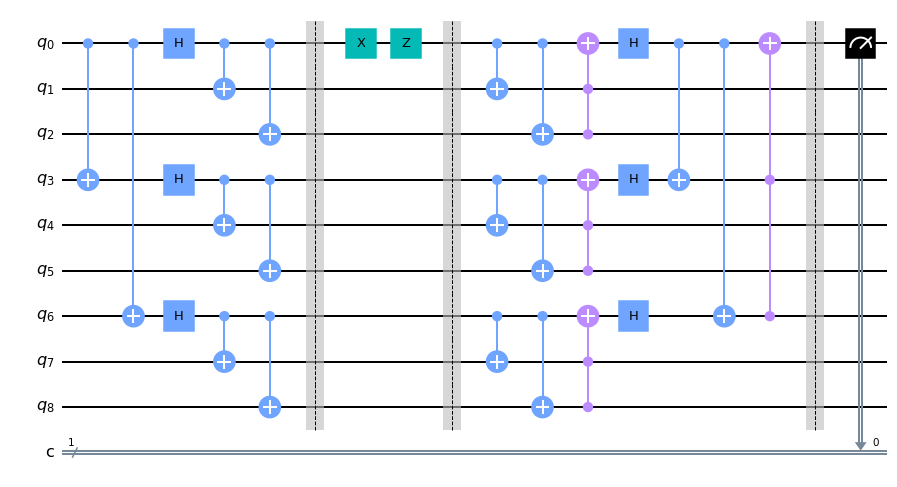

In [7]:
#####Shor code starts here ########
q = QuantumRegister(9,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.barrier(q)

####error here############
circuit.x(q[0])#Bit flip error
#circuit.x(q[5])#Bit flip error
#circuit.x(q[8])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.barrier(q)
circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.ccx(q[1],q[2],q[0])
circuit.ccx(q[4],q[5],q[3])
circuit.ccx(q[8],q[7],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])
circuit.ccx(q[6],q[3],q[0])

circuit.barrier(q)

circuit.measure(q[0],c[0])

circuit.draw()